In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Definition of basic functions

In [ ]:
def ODE(model, x, mu, k):
    """
    ODE 1D underdamped harmonic oscillator problem.
    """
    y = model(x)
    # computes dy/dx
    dydx  = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    # computes d^2y/dx^2
    dydx2 = torch.autograd.grad(dydx,  x, torch.ones_like(dydx),  create_graph=True)[0]
    # computes the 1D harmonic oscillator differential equation
    ode = dydx2 + mu*dydx + k*y
    return ode

def exact_solution(d, w0, x):
    """
    Analytical solution to the 1D underdamped harmonic oscillator problem.
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

class DNN(nn.Module):
    """
    Defines a connected network
    ============================================================================
    N_INPUT: number of input variables
    N_OUTPUT: number of output variables
    N_HIDDEN: number of units per hidden layer
    N_LAYERS: number of hidden layers
    ============================================================================
    """
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh   # The tanh activation restricts output to [-1, 1] 
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### Definition of the PINN and training using data from the known solution  and the differential equation.

Epoch:  1000  Loss:  0.3080715835094452
Epoch:  2000  Loss:  0.30720195174217224
Epoch:  3000  Loss:  0.3064737021923065
Epoch:  4000  Loss:  0.30297181010246277
Epoch:  5000  Loss:  0.20091673731803894
Epoch:  6000  Loss:  0.042555201798677444
Epoch:  7000  Loss:  0.021163970232009888
Epoch:  8000  Loss:  0.011693838983774185
Epoch:  9000  Loss:  0.009612098336219788
Epoch:  10000  Loss:  0.007820980623364449
Epoch:  11000  Loss:  0.005397348199039698
Epoch:  12000  Loss:  0.0022168660070747137
Epoch:  13000  Loss:  0.0006327377632260323
Epoch:  14000  Loss:  0.0003264511178713292
Epoch:  15000  Loss:  0.00025388377252966166
Epoch:  16000  Loss:  0.00022957600594963878
Epoch:  17000  Loss:  0.00022016350703779608
Epoch:  18000  Loss:  0.00021208103862591088
Epoch:  19000  Loss:  0.0002164127363357693
Epoch:  20000  Loss:  0.000202686816919595


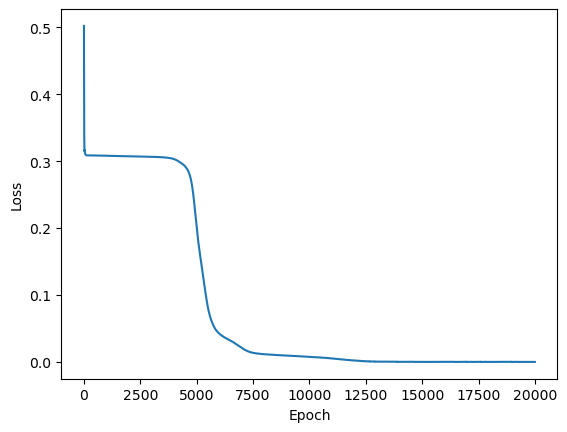

In [3]:
# Parameters in the differential equation
d, w0 = 2, 20
mu, k = 2*d, w0**2

# Domain of integration
x = torch.linspace(0,1,500).view(-1,1)
# Analytical solution over the full domain
y = exact_solution(d, w0, x).view(-1,1)

# Data points for the training ("data loss")
x_data = x[0:200:20]
y_data = y[0:200:20]


# Sample locations over the problem domain
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)



epochs = 20000
torch.manual_seed(413)
model = DNN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
loss_history = []

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error

    # compute the "physics loss"
    physics = ODE(model, x_physics, mu, k)
    loss2 = (1e-4)*torch.mean(physics**2)

    # Total loss
    loss = loss1 + loss2

    # backpropagate total loss
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if (i+1) %1000 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())



plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

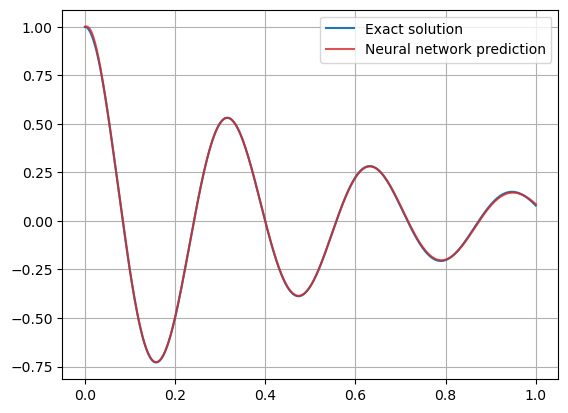

In [4]:
# Plot of the exact solution
xp = x
yp = model(x).detach()

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.plot(xp,yp, color="tab:red", alpha=0.8, label="Neural network prediction")
plt.legend()
plt.grid()
plt.show()
